# Кластеризация текстовой коллекции

### Подгрузим необходимые библиотеки

In [48]:
# !python -m pip install --upgrade pip
# !pip install pymorphy2
# !pip install spacy
import time
import pickle
import pymorphy2
from spacy.lang.ru import Russian
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation

### Получим данные

In [49]:
NUM_CLUSTERS = 5
categories = [
        'comp.graphics',
        'sci.space',
        'rec.autos',
        'sci.electronics',
        'rec.sport.hockey',
    ]
# dataset = fetch_20newsgroups(subset='train', categories=categories,
#                                  shuffle=True, random_state=42)
# print(time.time() - start_time)
# with open('20news_dataset_train.pickle', 'wb') as file:
#     pickle.dump(dataset, file)
# print(time.time() - start_time)
def get_data():
    with open('20news_dataset_train.pickle', 'rb') as file:
        dataset = pickle.load(file)
    return dataset


### Метод векторизации, поддерживаются BagOfWords и TFIDF подходы, возвращает разреженную матрицу признаков

In [50]:
def vectorize_data_custom():
    pass

def vectorize_data(vec_type, dataset):
    if vec_type == 'tf':
        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(dataset.data)
    elif vec_type == 'tfidf':
        vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', max_features=1000)
        X = vectorizer.fit_transform(dataset.data)
    return X, vectorizer.get_feature_names()

### Метод кластеризации, поддерживает выбор способа кластеризации передачей аргументов 'kmeans', 'dbscan', 'agglomerative', возвращает обученную модель

In [51]:
def cluster_data(clustering_type, X):
    if clustering_type == 'kmeans':
        model = KMeans(n_clusters=NUM_CLUSTERS).fit(X)
    elif clustering_type == 'dbscan':
        model = DBSCAN().fit(X)
    elif clustering_type == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=NUM_CLUSTERS).fit(X.todense())
    elif clustering_type == 'lda':
        model = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online', 
                                          learning_offset=50., random_state=0).fit(X)
    return model

### Метод визуализации многомерных данных с помощью t-SNE

In [52]:
# !pip install matplotlib
# !pip install seaborn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline
from sklearn.manifold import TSNE

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 5))

    f = plt.figure(figsize=(48, 48))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=100,
                    c=palette[colors.astype(np.int)])
    ax.axis('on')
    ax.axis('tight')

    txts = []
    for i in range(5):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=64)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

def visualize_clusters():
    pass
#     dataset = get_data()
#     X, feature_names = vectorize_data('tfidf', dataset)
#     kmeans = cluster_data('kmeans', X)
#     Y = kmeans.predict(X)
#     tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(X)
#     print(list(range(0,4)))
#     sns.palplot(np.array(sns.color_palette("hls", 4)))
#     scatter(tsne, Y)
#     plt.savefig('tsne-generated_18_clust_48_100.png', dpi=120)
    
#     dbscan = cluster_data('dbscan', X)
#     Y = dbscan.fit_predict(X)
#     print(list(range(0,4)))
#     sns.palplot(np.array(sns.color_palette("hls", 4)))
#     scatter(tsne, Y)
#     plt.savefig('tsne-generated_18_clust_48_100.png', dpi=120)

### Перейдём непосредственно к экспериментам

#### Во-первых, о сравнении BagOfWords и TFIDF: здесь вполне очевидны и преимущества, и недостатки обоих подходов. Более того, они взаимно вытекают друг из друга. BagOfWords быстро строится, однако больший вес отдаётся часто встречающимся в документе словам, никак не анализируется частота встречаемости слова на уровне коллекции. Таким образом, в нем большой вес могут получить просто общеупотребимые слова (даже с учетом отбрасывания стоп-слов), что однако никак не помогает нам "корректно" сравнивать полученные векторы между собой. TFIDF, напротив, строится дольше (это надстройка над подсчётом tf в BagOfWords), учитывается обратная документная частота термина, то есть редкость(для исследователя - важность) термина на уровне коллекции. Безусловно, в TFIDF больший вес получают действительно "полезные" для дальнейшего анализа фичи. Разница в скорости вычислений не настолько велика, чтобы отказаться от TFIDF. Мой выбор всегда в его пользу.

### Проведём сбор данных, векторизацию и кластеризацию описанными выше методами, смотрим время работы:

In [53]:
start_time = time.time()
dataset = get_data()
print(f'Collected data for {time.time() - start_time} seconds')

start_time = time.time()
X, feature_names = vectorize_data('tfidf', dataset)
print(f'Vectorized for {time.time() - start_time} seconds')

start_time = time.time()
kmeans = cluster_data('kmeans', X)
print(f'Clustering using KMeans has been processed for {time.time() - start_time} seconds')

start_time = time.time()
dbscan = cluster_data('dbscan', X)
print(f'Clustering using DBSCAN has been processed for {time.time() - start_time} seconds')

start_time = time.time()
agglomerative = cluster_data('agglomerative', X)
print(f'Clustering using AgglomerativeClustering has been processed for {time.time() - start_time} seconds')

start_time = time.time()
lda = cluster_data('lda', X)
print(f'Clustering using LatentDirichletAllocation has been processed for {time.time() - start_time} seconds')
print_top_words(lda, feature_names, 20)

print(categories)

Collected data for 0.019017696380615234 seconds
Vectorized for 0.5666277408599854 seconds
Clustering using KMeans has been processed for 27.63497757911682 seconds
Clustering using DBSCAN has been processed for 0.44694018363952637 seconds
Clustering using AgglomerativeClustering has been processed for 3.7586448192596436 seconds
Clustering using LatentDirichletAllocation has been processed for 2.6835529804229736 seconds
Topic #0: edu com graphics lines subject university organization thanks ac need use help posting does uk host nntp know like looking
Topic #1: edu com car ca writes article subject organization team lines university game don just hockey cars like think posting host
Topic #2: access digex pat prb water cooling nuclear online communications net com usa ti dseg posting probe host nntp venus wings
Topic #3: __ ___ jpl baalke kelvin _____ comet ____ ron jupiter gov propulsion nasa orbit lab april vms laboratory vax venus
Topic #4: space edu nasa gov henry alaska moon writes or

### Визуализация результата работы KMeans с помощью t-SNE:

[0, 1, 2, 3]


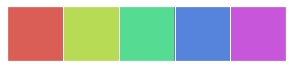

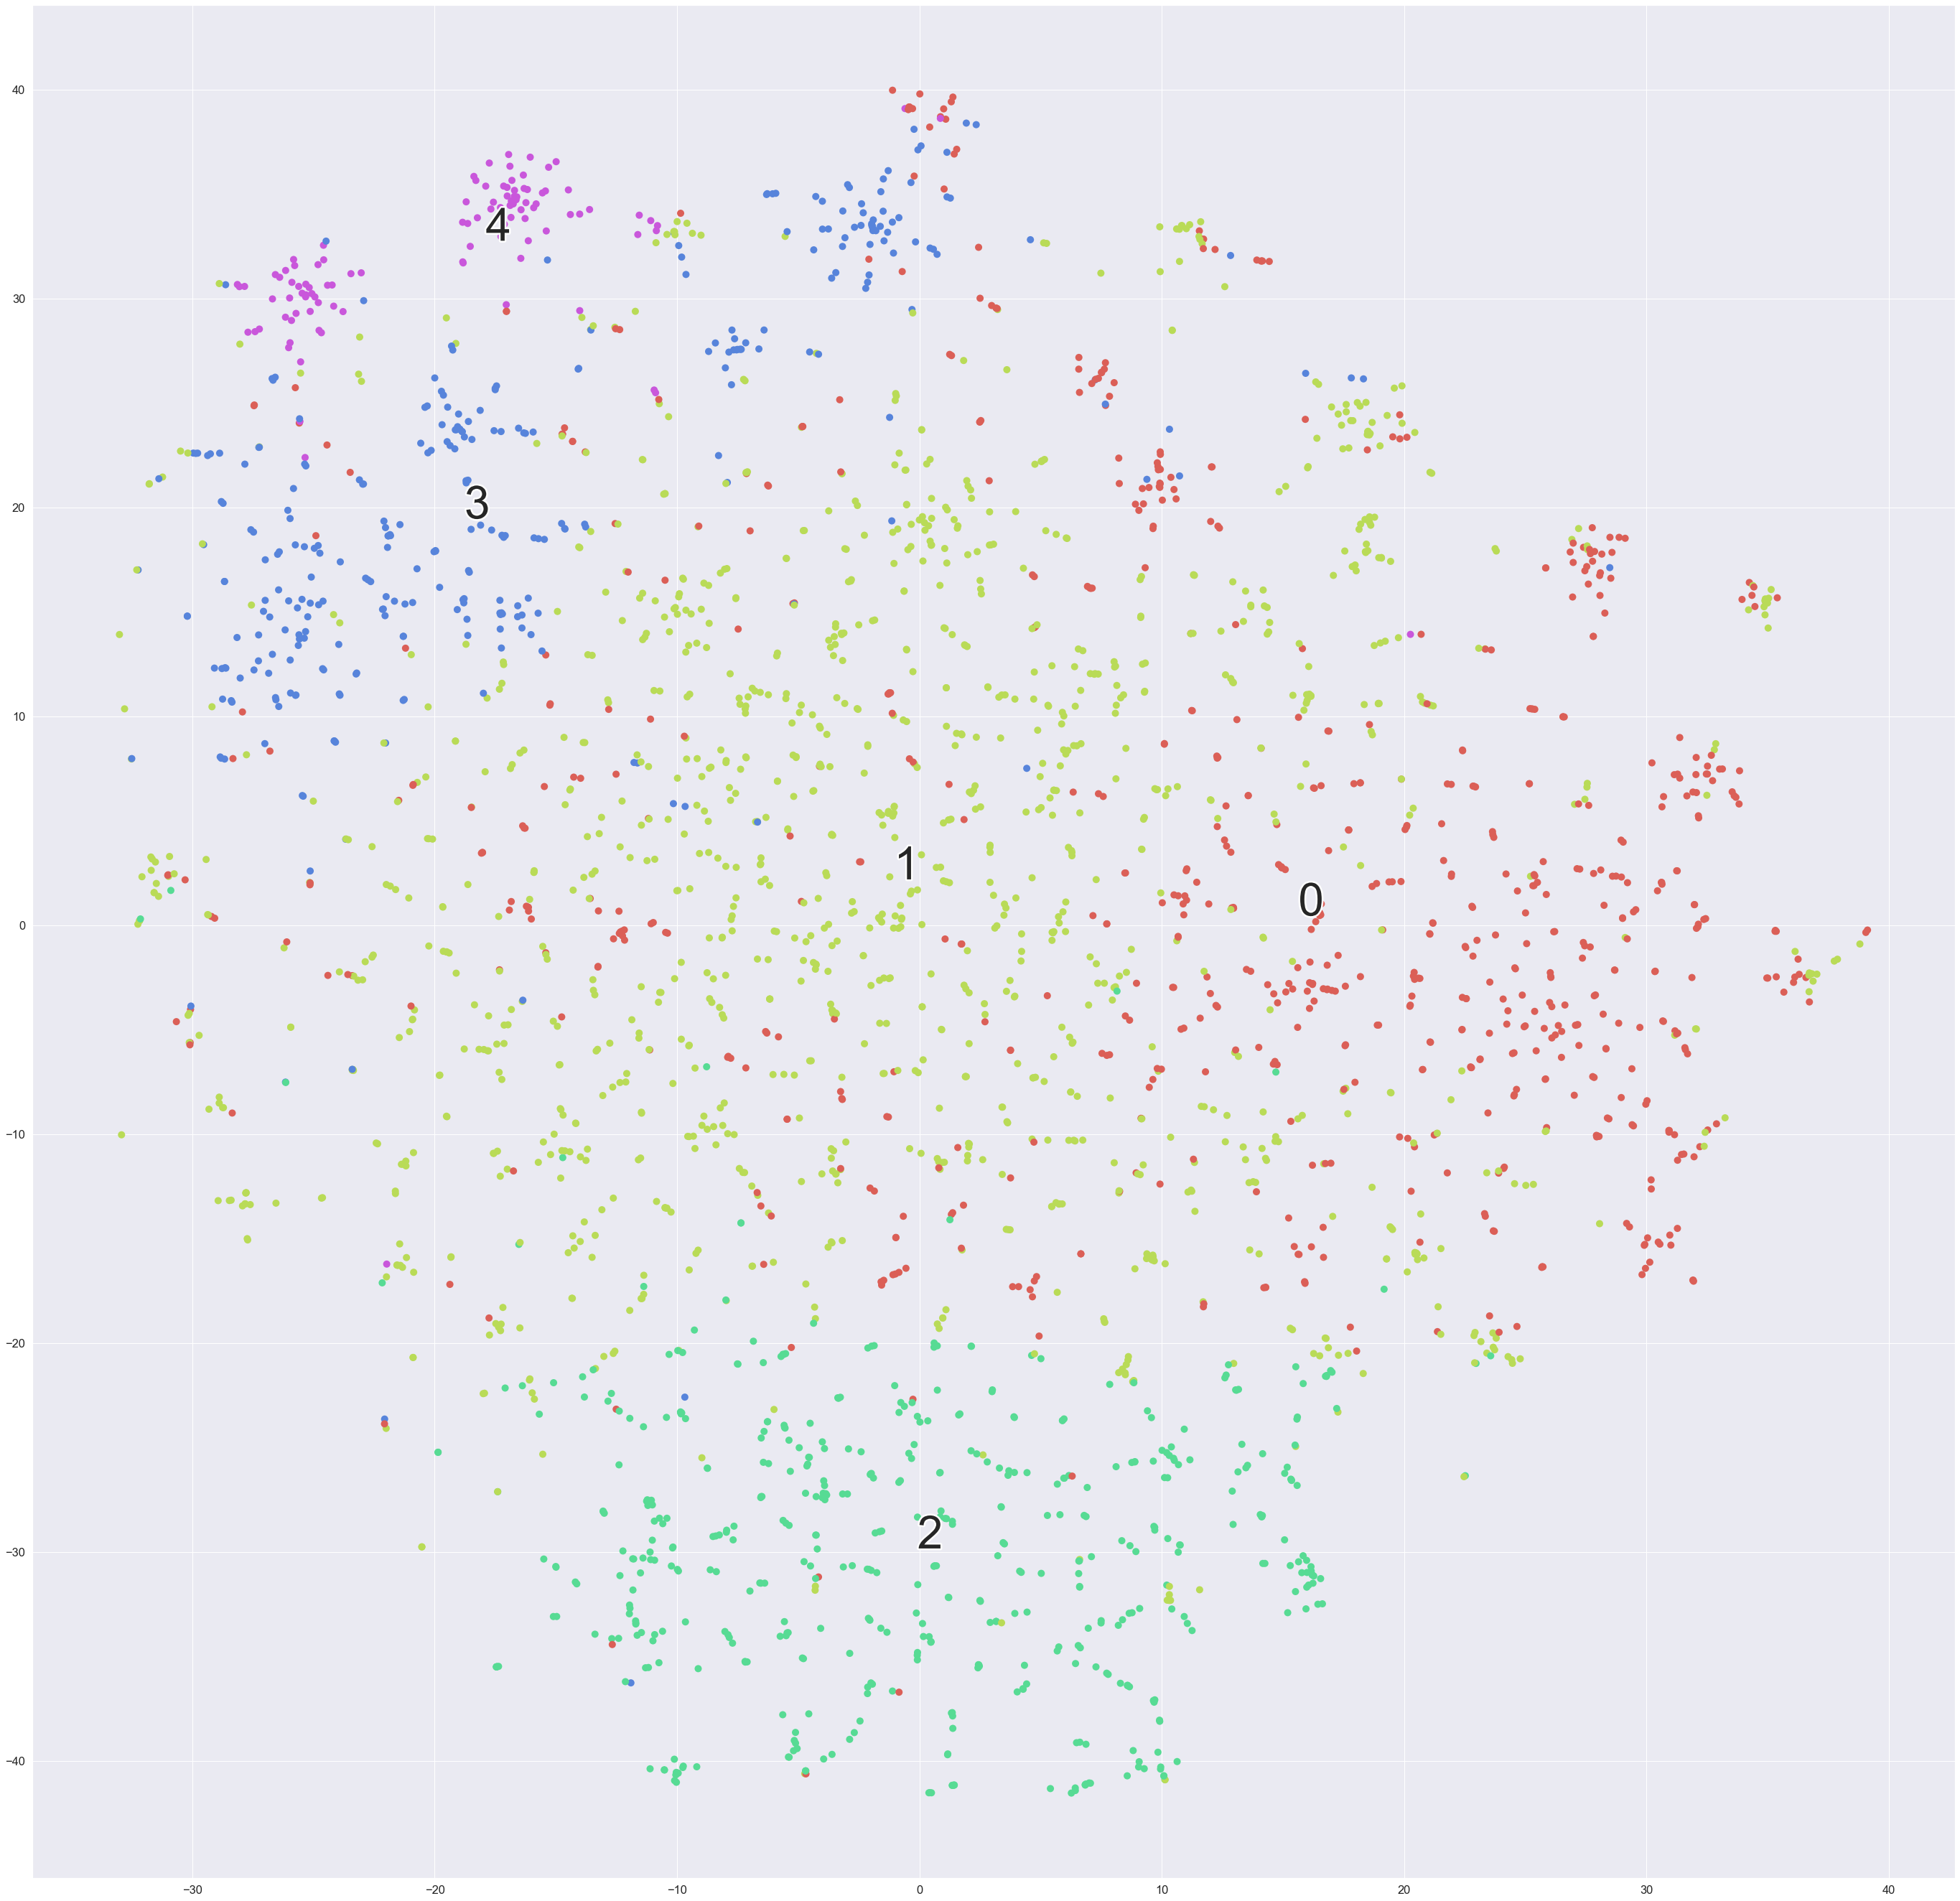

In [54]:
Y = kmeans.predict(X)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(X)
print(list(range(0,4)))
sns.palplot(np.array(sns.color_palette("hls", 5)))
scatter(tsne, Y)
plt.savefig('tsne-generated_5_clust.png', dpi=120)

In [55]:
def easy_scatter(figure_num, reduced, X, model):
    plt.figure(figure_num)
    plt.title('TSNE')
    plt.scatter(reduced[:,0], reduced[:,1], c=model.fit_predict(X))

### Визуализация результата работы DBSCAN с помощью t-SNE:

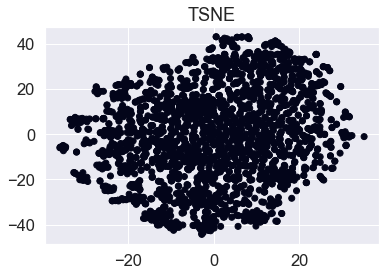

In [56]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(X.toarray())
easy_scatter(1, tsne, X, dbscan)

### Визуализация результата работы AgglomerativeClustering с помощью t-SNE:

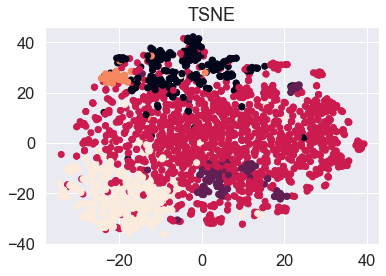

In [57]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300).fit_transform(X.toarray())
easy_scatter(1, tsne, X.todense(), agglomerative)

### Вспомогательный метод для кластеризации с помощью Latent Dirichlet Allocation:

In [58]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

## Выводы:

### Полученная визуализация результатов работы DBSCAN не позволяет оценить качество кластеризации. KMeans и AgglomerativeClustering дали неплохой результат, причем AgglomerativeClustering обучается сильно быстрее. 
### Topic Modelling подход также неплохо себя показал, однако среди топ-слов встречаются повторы между разными топиками. В идеале хотелось бы иметь все же как можно больше уникальных топ-фичей для каждого кластера.